In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from mldec.hardware.topological_codes.postprocessing import reshape_and_verify_correspondence
from mldec.datasets.reps_exp_rep_code_data import build_syndrome_2D, make_exp_dataset_name, load_data

import numpy as np


### Compute (bulk) detector fraction

In [27]:
def make_visualization_by_round(X):
    """Make a histogram of several properties of the syndromes.

    We will return two histograms:
        histogram_by_round: The histogram over all (single-round) syndromes, aggregated
         between different rounds.
         histogram_by_bit: Histogram over all bit-positions in the 2D syndrome, aggregated
         over the n-1 bits in the syndrome.
    
    X has shape (n_data, repetitions, n-1). """

    histogram_by_round = np.zeros(X.shape[2] + 1)
    histogram_by_bit = np.zeros(X.shape[1] + 1)
    out = np.zeros(X.shape[2] + 1)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            histogram_by_round[int(np.sum(X[i, j,:]))] += 1
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            histogram_by_bit[int(np.sum(X[i, :, j]))] += 1
    histogram_by_round = histogram_by_round / np.sum(histogram_by_round)
    histogram_by_bit = histogram_by_bit / np.sum(histogram_by_bit)
    return histogram_by_round, histogram_by_bit


def convert_to_detector(X):
    """
    Args:
        X: Shape (n_trials, repetitions, n-1)
    """
    out = np.logical_xor(X[:,:-1,:], X[:,1:,:])
    return out

def compute_bulk_detection_fraction(X, bulk_only=False):
    """Compute the fraction of syndrome flips in a given dataset.

    """
    detector = convert_to_detector(X)
    if bulk_only:
        X = X[:,:,1:-1]
    return np.sum(detector) / (X.shape[0] * X.shape[1] * X.shape[2])

# all_n_T = [(5, 5), (5, 6), (5, 7), (6, 6), (7, 7), (8, 8), (9, 10), (11, 10)]
all_n_T = [(5, 5), (6, 6), (7, 7), (8, 8),  (11, 10)]
results_by_n_T = []
delay_factors = [0, 1, 1.1, 1.2, 1.3, 1.4, 2, 3, 4, 5]


for (n, T) in all_n_T:
    p_det_arr = []
    for delay_factor in delay_factors:
        fname = make_exp_dataset_name(n, T, delay_factor)
        X, y = load_data(fname)
        p_det_arr.append(compute_bulk_detection_fraction(X, bulk_only=False))
    results_by_n_T.append(p_det_arr)


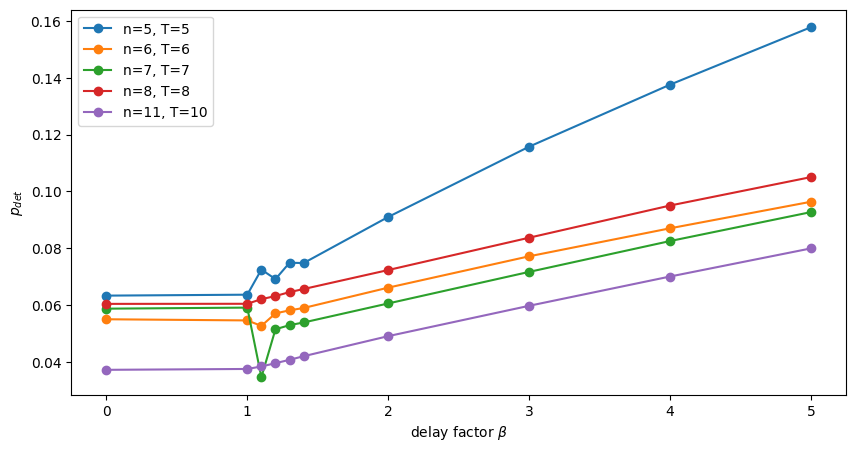

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, (n, T) in enumerate(all_n_T):
    ax.plot(delay_factors, results_by_n_T[i], label=f"n={n}, T={T}", marker="o")

ax.legend()
ax.set_xlabel(r"delay factor $\beta$")
ax.set_ylabel(r"$p_{det}$")
# ax.set_title("Bulk detection fraction by n and T")
plt.savefig("bulk_detection_fraction_by_n_T.png")

In [42]:

# all_n_T = [(5, 5), (6, 6), (7, 7), (8, 8)]
all_n_T = [(3, 5)]
results_by_n_T = []
num_repeats_plus_one_arr = [1, 10]



for (n, T) in all_n_T:
    p_det_arr = []
    for num_repeats_plus_one in num_repeats_plus_one_arr:
        fname = make_exp_dataset_name(n, T, 1, delay_plus_one=num_repeats_plus_one)
        X, y = load_data(fname)
        p_det_arr.append(compute_bulk_detection_fraction(X, bulk_only=False))
    results_by_n_T.append(p_det_arr)




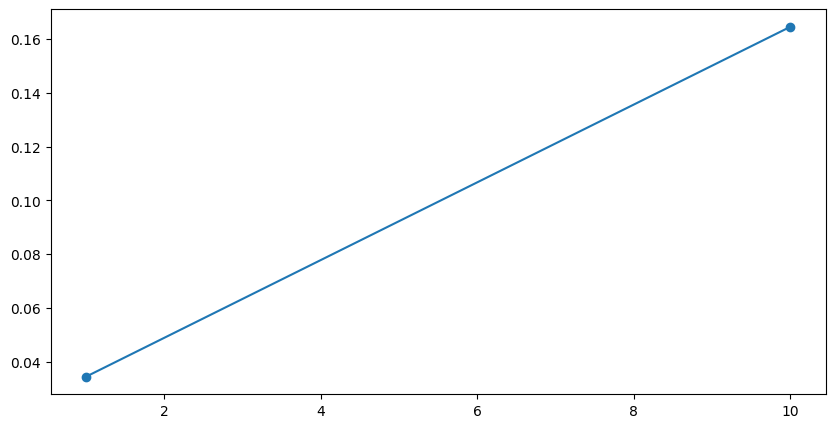

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, (n, T) in enumerate(all_n_T):
    ax.plot(num_repeats_plus_one_arr, results_by_n_T[i], label=f"n={n}, T={T}", marker="o")


In [ ]:

ANALYZE_DATA = 2
if ANALYZE_DATA == 1:


    for (n, T) in [(5, 5), (5, 6), (5, 7), (9, 10)]:
        fig, ax = plt.subplots(1, 2, figsize=(13, 6))
        # load the data
        out = {}
        for delay_factor in delay_factors:
            fname = make_exp_dataset_name(n, T, delay_factor)
            X, y = load_data(fname)
            out[delay_factor] = (X, y)


        for beta, (X, y) in out.items():
            # these are not the syndromes, but rather the syndrome difference per round.
            syndromes = np.array([build_syndrome_2D(X[i,:,:]) for i in range(X.shape[0])])
            syndromes = syndromes.reshape(X.shape)
            histogram_by_round, histogram_by_bit = make_visualization_by_round(syndromes)
            ax[0].plot(range(len(histogram_by_round)), histogram_by_round, label=f"beta={beta}", marker="o")
            ax[1].plot(range(len(histogram_by_bit)), histogram_by_bit, label=f"beta={beta}", marker="o")
            
        ax[0].legend()
        ax[1].legend()
        ax[0].set_xlabel("weight of syndrome")
        ax[1].set_xlabel("weight over all time")
        ax[0].set_ylabel("fraction of syndromes")
        ax[0].semilogy()
        ax[1].semilogy()
        plt.savefig(f"syndrome_weights_n{n}_T{T}.png")

elif ANALYZE_DATA == 2:
    n = 9
    T = 10
    out = {}
    for delay_factor in delay_factors[1:]:
        fname = make_exp_dataset_name(n, T, delay_factor)
        X, y = load_data(fname)
        out[delay_factor] = (X, y)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))

    for beta, (X, y) in out.items():
        for i in range(3):
            # get a random subset of range(9):
            indices = np.arange(i, i+5)
            X_subset = X[:,:,indices]
            # these are not the syndromes, but rather the syndrome difference per round.
            syndromes = np.array([build_syndrome_2D(X_subset[i,:,:]) for i in range(X_subset.shape[0])])
            syndromes = syndromes.reshape((X.shape[0], X.shape[1], 5))

            histogram_by_round, histogram_by_bit = make_visualization_by_round(syndromes)
            axes[i].plot(range(len(histogram_by_round)), histogram_by_round, label=f"beta={beta}", marker="o")
            axes[i].legend()
            axes[i].semilogy()
            axes[i].set_xlabel("weight of syndrome")
            axes[i].set_ylabel("fraction of syndromes")
            axes[i].set_title(f"subset {indices}")

    plt.savefig(f"syndrome_weights_n{n}_T{T}_subset5.png",  bbox_inches="tight")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    slices = range(4, 9)
    for beta, (X, y) in out.items():
        for i, x in enumerate(slices):
            # get a random subset of range(9):
            X_subset = X[:,:,:x]
            # these are not the syndromes, but rather the syndrome difference per round.
            syndromes = np.array([build_syndrome_2D(X_subset[i,:,:]) for i in range(X_subset.shape[0])])
            syndromes = syndromes.reshape((X.shape[0], X.shape[1], x))

            histogram_by_round, histogram_by_bit = make_visualization_by_round(syndromes)
            axes[i].plot(range(len(histogram_by_round)), histogram_by_round, label=f"beta={beta}", marker="o")
            axes[i].legend()
            axes[i].semilogy()
            axes[i].set_xlabel("weight of syndrome")
            axes[i].set_ylabel("fraction of syndromes")

    plt.savefig(f"syndrome_weights_n{n}_T{T}_subset5678.png", bbox_inches="tight")


In [ ]:
import matplotlib.pyplot as plt
from mldec.hardware.topological_codes.postprocessing import reshape_and_verify_correspondence
from mldec.datasets.reps_exp_rep_code_data import build_syndrome_2D, make_exp_dataset_name, load_data

import numpy as np


### Load data and look at syndrome distr by weight

In [6]:
def make_visualization_by_round(X):
    """Make a histogram of the (weights) of (modded) syndromes in the experimental data.
    
    X has shape (n_data, repetitions, n-1). """

    out = np.zeros(X.shape[2] + 1)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            out[int(np.sum(X[i, j]))] += 1
    return out / np.sum(out)

In [10]:
X.shape

(512, 6, 4)

Text(0.5, 1.0, 'Histogram of syndrome weights')

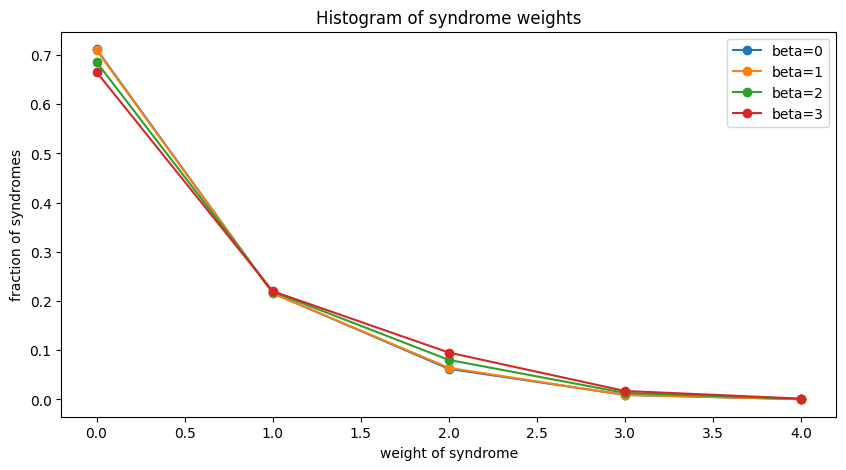

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

delay_factors = [0, 1, 2, 3]
n = 5
T = 6

# load the data
out = {}
for delay_factor in delay_factors:
    fname = make_exp_dataset_name(n, T, delay_factor)
    X, y = load_data(fname)
    out[delay_factor] = (X, y)


for beta, (X, y) in out.items():
    syndromes = np.array([build_syndrome_2D(X[i,:,:]) for i in range(X.shape[0])])
    syndromes = syndromes.reshape(X.shape)
    hist = make_visualization_by_round(syndromes)
    ax.plot(range(len(hist)), hist, label=f"beta={beta}", marker="o")
    
ax.legend()
ax.set_xlabel("weight of syndrome")
ax.set_ylabel("fraction of syndromes")
ax.set_title("Histogram of syndrome weights")
# ax.semilogy()
